In [1]:
import torch 
from torch import nn
import torch.nn.functional as F
import math

In [ ]:
X = torch.randn(128,64,512) # batch_size, num_heads, dim
# Time 代表时间步长，是一个序列的长度
# dim   代表每个时间步的维度,是一个向量的长度
d_model = 512 
# 映射到d_k的维度
n_head = 8
# 有几个头

In [ ]:
class MultiHeadAttention(nn.Module):
    def __init__(self, d_model, n_head):
        super(MultiHeadAttention, self).__init__()
        self.d_model = d_model
        self.n_head = n_head
        # 初始的向量维度是512, 经过线性映射到512
        # 经过线性映射到8*64=512, 也就是8个头，每个头64维
        self.linear_q = nn.Linear(d_model, d_model)
        self.linear_k = nn.Linear(d_model, d_model)
        self.linear_v = nn.Linear(d_model, d_model)
        self.w_combine = nn.Linear(d_model, d_model)
        # 由于是多头注意力，所以要对每个头的输出进行拼接
        # 然后再经过线性映射到512维度
        self.softmax = nn.Softmax(dim=-1)
    def forward(self,q,k,v):
        batch,time,dimension = q.shape
        n_d = self.d_model // self.n_head
        q,k,v = self.linear_q(q),self.linear_k(k),self.linear_v(v)

        # 将 q, k, v 的形状从 (batch, time, dimension) 转换为 (batch, n_head, time, n_d)
        # 其中 n_d 是每个头的维度大小，即 d_model // n_head
        # 然后要把它们的形状转换为 (batch, time, n_head, n_d)
        # 这样做的目的是为了方便后续的计算
        q = q.view(batch, time, self.n_head, n_d).permute(0, 2, 1, 3)
        k = k.view(batch, time, self.n_head, n_d).permute(0, 2, 1, 3)
        v = v.view(batch, time, self.n_head, n_d).permute(0, 2, 1, 3)

        score = q @ k.transpose(-2, -1) / math.sqrt(n_d)
        # score的形状是 (batch, n_head, time, time)
        # k 的形状是 (batch, n_head, time, n_d)
        # q 的形状是 (batch, n_head, time, n_d)
        mask = torch.tril(torch.ones(time, time,dtype=bool)).to(q.device)
        score = score.masked_fill(mask == 0, -1e9)
        score = self.softmax(score) @ v

        # score的形状是 (batch, n_head, time, n_d)
        # 这里重新调整 score 的形状为 (batch, time, n_head, n_d) 
        # contiguous() 是为了保证内存连续性
        score = score.permute(0, 2, 1, 3).contiguous().view(batch, time, self.d_model)
        # score的形状是 (batch, time, dimension)
        # 多头QKV 是多个head 的QKV拼接在一起
        # 经过线性映射到512维度
        score = self.w_combine(score)
        return score
attention = MultiHeadAttention(d_model, n_head)
out = attention(X,X,X)
print(out,out.shape)
# 得到的是一个512维的向量，这是该向量在所有时间步上的加权平均值
# 这个向量表示了该时间步的上下文信息

tensor([[[-2.5781e-01,  2.6914e-01, -1.0932e-01,  ..., -4.8894e-02,
          -1.3164e-01,  5.0330e-01],
         [-5.9104e-02,  3.1367e-01,  2.7948e-01,  ...,  6.6517e-02,
           9.9019e-02,  3.2811e-01],
         [-1.0604e-01,  2.2632e-01,  2.1824e-01,  ...,  9.9611e-02,
           1.2885e-01,  3.0407e-01],
         ...,
         [-6.5358e-02,  7.8551e-02, -8.6854e-03,  ..., -2.9055e-02,
           5.0001e-02,  6.4664e-04],
         [-6.4939e-02,  4.7746e-02, -2.1559e-02,  ..., -4.7592e-02,
           2.4071e-02, -1.4415e-02],
         [-7.9249e-02,  7.0874e-02,  3.1428e-03,  ..., -3.8401e-02,
           5.5932e-02, -2.9165e-02]],

        [[-1.4077e-01, -1.3992e-01,  4.8504e-01,  ..., -1.9872e-01,
          -7.0543e-01,  1.7292e-01],
         [ 1.7119e-01, -7.4643e-02,  8.9912e-02,  ..., -1.9454e-01,
          -2.3836e-01,  6.0003e-02],
         [ 1.4811e-01, -1.0998e-01,  1.0880e-01,  ...,  5.7704e-02,
          -1.7024e-01,  2.1530e-01],
         ...,
         [-8.3295e-02, -3

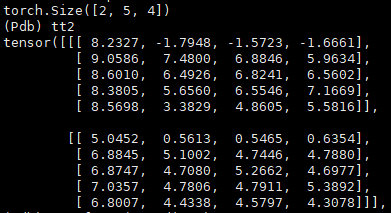
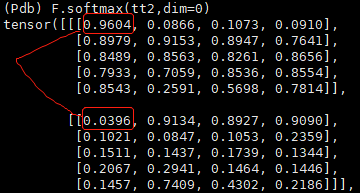
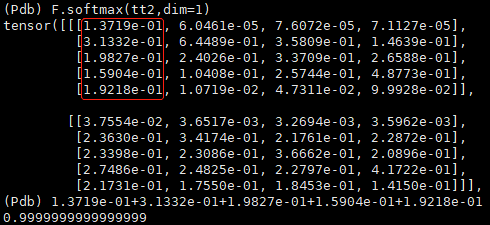
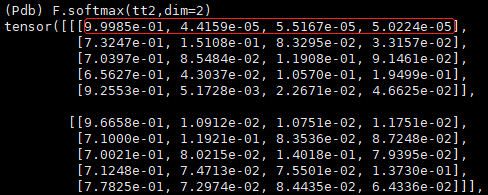
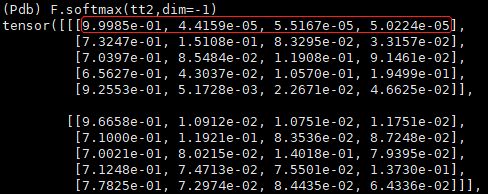

# Token Embedding


In [9]:
class TokenEmbedding(nn.Embedding):
    def __init__(self, vocab_size, d_model):
        super(TokenEmbedding, self).__init__(vocab_size, d_model, padding_idx=1)

class TokenEmbeddingManual(nn.Module):
    def __init__(self, vocab_size, d_model):
        super(TokenEmbeddingManual, self).__init__()
        self.vocab_size = vocab_size
        self.d_model = d_model
        # 这里的参数是一个可学习的参数
        self.embedding = nn.Parameter(torch.randn(vocab_size, d_model))

    def forward(self, x):
        return self.embedding[x]
    def __getitem__(self, idx): 
        return self.embedding[idx]
    def __len__(self): 
        return self.vocab_size
    def __repr__(self): 
        return f"TokenEmbeddingManual(vocab_size={self.vocab_size}, d_model={self.d_model})"
    def __str__(self): 
        return self.__repr__()
# 测试 TokenEmbedding
token_embedding = TokenEmbedding(100, 512)
x = torch.randint(0, 100, (128, 64)) # batch_size, seq_len
out1 = token_embedding(x)
print(out1.shape,out1) # (128, 64, 512)

# 测试 TokenEmbeddingManual
token_embedding_manual = TokenEmbeddingManual(100, 512)
out2 = token_embedding_manual(x)
print(out2.shape,out2) # (128, 64, 512)

# 给定一串文本
text = ["hello", "world", "this", "is", "a", "test"]
vocab = {word: idx for idx, word in enumerate(set(text))}
vocab_size = len(vocab)
text_indices = torch.tensor([vocab[word] for word in text])

# 使用 TokenEmbedding 和 TokenEmbeddingManual 生成嵌入
token_embedding = TokenEmbedding(vocab_size, d_model)
token_embedding_manual = TokenEmbeddingManual(vocab_size, d_model)

# 获取嵌入
embedding_out1 = token_embedding(text_indices)
embedding_out2 = token_embedding_manual(text_indices)

# 打印结果
print("Text:", text)
print("Indices:", text_indices)
print("TokenEmbedding output shape:", embedding_out1)
print("TokenEmbeddingManual output shape:", embedding_out2)

    

torch.Size([128, 64, 512]) tensor([[[-1.2953, -1.2702, -0.8017,  ..., -0.7023,  0.1339,  0.0128],
         [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.4605,  0.0935,  0.3662,  ...,  1.1938, -0.0136, -0.6557],
         ...,
         [-0.5049,  1.5743,  0.1677,  ..., -0.3076,  0.4958, -0.1578],
         [-0.1817, -0.4622, -1.5435,  ...,  1.9230,  1.4323, -0.8766],
         [ 0.4550, -0.4436,  0.8198,  ..., -0.0983, -0.3097,  0.8644]],

        [[ 2.0353, -0.1494, -0.1231,  ...,  0.5635, -2.0532, -1.8679],
         [ 0.1840, -0.1294,  1.0158,  ...,  0.9826,  0.1281,  0.0640],
         [-1.2953, -1.2702, -0.8017,  ..., -0.7023,  0.1339,  0.0128],
         ...,
         [-1.0317, -0.2699, -1.8661,  ...,  0.3852,  0.3605,  0.1817],
         [-1.9177,  0.6005,  1.0958,  ...,  2.2307,  0.2638,  2.0045],
         [-0.0800, -0.2056, -1.6293,  ...,  0.9444,  1.6253,  0.1731]],

        [[-1.0671,  0.5386,  1.1126,  ..., -0.1795, -0.2472,  0.2412],
         [-0.6197,

# Position Embedding

In [14]:
class PositionalEmbedding(nn.Module):
    def __init__(self, d_model, max_len, device):
        super(PositionalEmbedding, self).__init__()
        self.encoding = torch.zeros((max_len, d_model), device=device)
        self.encoding.requires_grad = False

        pos = torch.arange(0, max_len, device=device).float().unsqueeze(1)
        _2i = torch.arange(0, d_model, 2, device=device).float()
        self.encoding[:, 0::2] = torch.sin(pos / (10000 ** (_2i / d_model)))
        self.encoding[:, 1::2] = torch.cos(pos / (10000 ** (_2i / d_model)))

    def forward(self, x):
        seq_len = x.size(1)
        return self.encoding[:seq_len, :]

# 测试 PositionalEmbedding
d_model = 512
pos_embedding = PositionalEmbedding(d_model, 10, device='cpu')
x = torch.randn(128, 64, 512)  # batch_size, seq_len, d_model
out = pos_embedding(x)
print(out)  # (64, 512)


tensor([[ 0.0000e+00,  1.0000e+00,  0.0000e+00,  ...,  1.0000e+00,
          0.0000e+00,  1.0000e+00],
        [ 8.4147e-01,  5.4030e-01,  8.2186e-01,  ...,  1.0000e+00,
          1.0366e-04,  1.0000e+00],
        [ 9.0930e-01, -4.1615e-01,  9.3641e-01,  ...,  1.0000e+00,
          2.0733e-04,  1.0000e+00],
        ...,
        [ 6.5699e-01,  7.5390e-01,  4.5239e-01,  ...,  1.0000e+00,
          7.2564e-04,  1.0000e+00],
        [ 9.8936e-01, -1.4550e-01,  9.9067e-01,  ...,  1.0000e+00,
          8.2931e-04,  1.0000e+00],
        [ 4.1212e-01, -9.1113e-01,  6.7637e-01,  ...,  1.0000e+00,
          9.3297e-04,  1.0000e+00]])
